# The Leaky Integrate-and-Fire (LIF)

We are now considering to numerically simulate and study the "leaky" Integrate-and-Fire model neuron. This model is uniquely characterised by a single state-variable (i.e. the membrane potential $V(t)$), which evolves in time below the threshold $\theta$ for emission of action potentials, according to a simple first-order ordinary differential equation, whose *external input* is $I$ - here considered to be constant in time:

$$C \frac{dV(t)}{dt} = \frac{E - V}{R} + I$$

Whenever $V(t)$ hits the threshold $\theta$, a spike *is said to occur* (but not explicitly modelled) and $V(t)$ is reset to its resting potential $E$ and kept there for a refractory period $\tau_{arp}$.

Let's define the (biophysical) parameters of the model and some key numerical simulation variables.

In [2]:
# @title Import necessary Python libs and set parameters
import numpy as np
import matplotlib.pyplot as plt

# Configure plots for inline display in the notebook
%matplotlib inline

# Biophysical Parameters
R = 20.    # Membrane (specific) resistance [MOhm/cm^2]
C = 1.     # Membrane (specific) capacitance [uF/cm^2]
E = -70.   # Membrane resting potential [mV]
θ = -50.   # Excitability threshold [mV]
Vmax = 10.   # Peak voltage during a spike [mV] - purely aesthetical reasons!
Tarp = 10.   # Absolute refractory period [ms]

# Simulation Parameters
Δt = 0.1    # Integration time step [ms]

# Note: T, time, and N are now defined within the simulation cells
# to prevent scope bugs when re-running cells.

In [3]:
# @title Simulation functions definition
def IF(I, T=300.):
    """Simulates the LIF model for a constant current I."""
    # Set up time array
    time = np.arange(0, T + Δt, Δt)
    N = len(time)

    W = np.zeros(N)   # Array containing V as the time goes by
    Nspikes = 0         # Counter for the number of spikes

    # Initial conditions:
    V = E           # Membrane voltage of the cell [mV]
    ko = -100       # Last time (as index) an action potential occurred

    # Euler method ---------------------------------------------------------------
    for k in range(N): # Loop over each discrete step for time t

        if V >= θ:     # Ops! V just exceeded the threshold: an AP will occur!
            W[k] = Vmax  # This is only "aesthetic"
            V = E        # V is then re-set to the resting potential, after an AP.
            ko = k       # The last time an AP occurred is updated with the current time.
            Nspikes += 1
        elif (k - ko) < (Tarp / Δt): # Otherwise, is the neuron still "refractory" ?
            V = E        # Then V does not change in time: it must be kept "clamped"
            W[k] = E
        else:            # Otherwise
            # V evolves, integrating I... (Euler step)
            dV_dt = (E - V) / (R * C) + I / C
            V = V + dV_dt * Δt
            W[k] = V

    freq = (1000. * Nspikes) / T

    return time, W, round(freq)


def IF2(Iext, T=50.):
    """Simulates the LIF model for a time-varying current array Iext."""
    N = len(Iext)
    W = np.zeros(N)   # Array containing V as the time goes by
    Nspikes = 0         # Counter for the number of spikes

    # Initial conditions:
    V = E           # Membrane voltage of the cell [mV]
    ko = -100       # Last time (as integer) an action potential occurred

    # Euler method ---------------------------------------------------------------
    for k in range(N): # Loop over each discrete step for time t

        if V >= θ:     # Ops! V just exceeded the threshold: an AP will occur!
            W[k] = Vmax  # This is only "aesthetic"
            V = E        # V is then re-set to the resting potential, after an AP.
            ko = k       # The last time an AP occurred is updated with the current time.
            Nspikes += 1
        elif (k - ko) < (Tarp / Δt): # Otherwise, is the neuron still "refractory" ?
            V = E        # Then V does not change in time: it must be kept "clamped"
            W[k] = E
        else:            # Otherwise
            # V evolves, integrating I...
            dV_dt = (E - V) / (R * C) + Iext[k] / C
            V = V + dV_dt * Δt
            W[k] = V

    freq = (1000. * Nspikes) / T

    return W, round(freq)

def plot_all(xa, ya, xb, yb):
    """Helper function for plotting V(t) and another trace."""
    # Plotting instructions ------------------------------------------------------
    plt.figure(figsize=(10, 6))

    plt.plot(xa, ya,
             label="Numerical solution (V(t))",
             linewidth=3,
             color='black')

    plt.plot(xb, yb,
             label="Analytical solution / Input Current",
             linewidth=1.5,
             color='blue',
             linestyle='--')

    plt.xlabel("time [ms]", fontsize=14)
    plt.ylabel("Membrane potential [mV]", fontsize=14)

    # Replicate framestyle = :origin from Julia's Plots.jl
    ax = plt.gca()
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    ax.tick_params(labelsize=12)
    plt.legend(loc='upper right')

# Play with the amplitude of the external current $I$

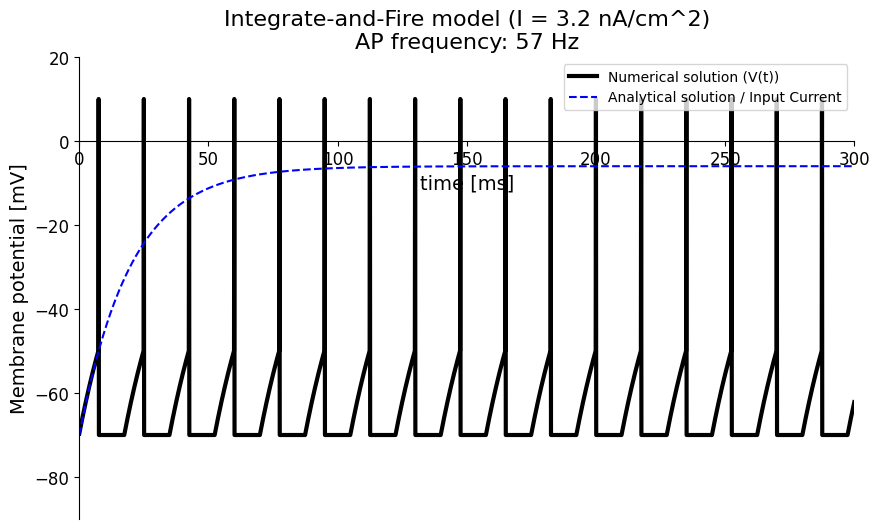

In [4]:
# @title After running this cell manually, it will auto-run if you change the selected value. { run: "auto" }
I = 3.2 #@param {type:"slider", min:-1, max:5, step:0.1}

T_sim = 300. # Set T for this simulation
time, W, freq = IF(I, T=T_sim)

# Analytical solution for the sub-threshold RC circuit
# V_inf = E + R*I, V(t) = V_inf + (V0 - V_inf) * exp(-t/tau)
V_inf = E + R * I
tau = R * C
Wanalyt = V_inf + (E - V_inf) * np.exp(-time / tau)

# Plotting
plot_all(time, W, time, Wanalyt) # Call the helper function

# Add titles and limits
plt.title(f"Integrate-and-Fire model (I = {I:.1f} nA/cm^2)\nAP frequency: {freq} Hz", fontsize=16)
plt.xlim(0, T_sim)
plt.ylim(-90, 20)
plt.show()

# Explore absolute refractoryness

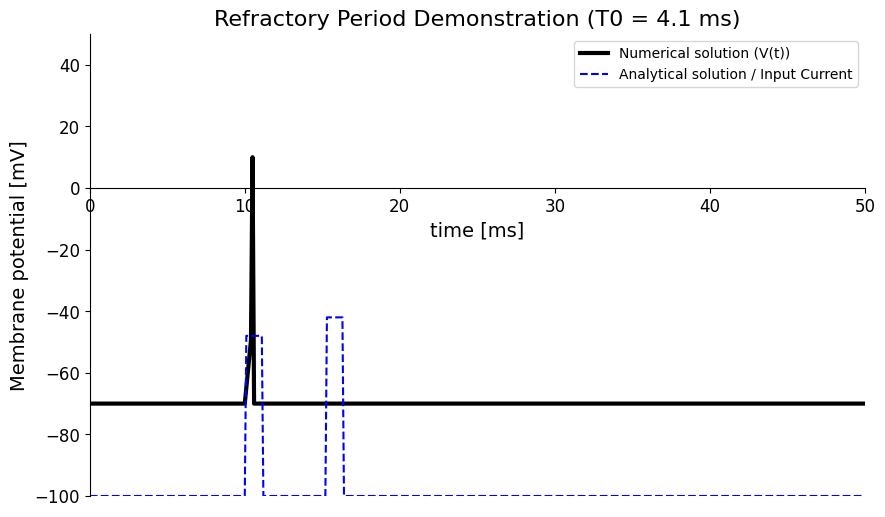

In [5]:
# @title After running this cell manually, it will auto-run if you change the selected value. { run: "auto" }
T = 50. # Total simulation time [ms]
I0 = 52 #@param {type:"slider", min:0, max:100, step:1}
I1 = 58 #@param {type:"slider", min:0, max:100, step:1}
T0 = 4.1 #@param {type:"slider", min:0.1, max:50, step:1}

delay = 10. # [ms] time of first pulse

# Define the time array for this simulation
time = np.arange(0, T + Δt, Δt)
Iext = np.zeros(len(time))

# Duration of pulses (11 steps = 1.1 ms, matching original notebook)
pulse_steps = 11
pulse_duration = pulse_steps * Δt

# --- Pythonic way to build the Iext array ---
# Find indices for pulses (adding/subtracting a small epsilon for float safety)
t_pulse1_start = delay + Δt
t_pulse1_end = t_pulse1_start + pulse_duration

t_pulse2_start = t_pulse1_end + T0
t_pulse2_end = t_pulse2_start + pulse_duration

idx1 = np.where((time >= t_pulse1_start - 1e-5) & (time < t_pulse1_end - 1e-5))
idx2 = np.where((time >= t_pulse2_start - 1e-5) & (time < t_pulse2_end - 1e-5))

Iext[idx1] = I0
Iext[idx2] = I1
# --- End of Iext creation ---

# Run the simulation
# We pass T so the IF2 function can correctly calculate frequency
W2, freq2 = IF2(Iext, T=T)

# Plot the results
# We plot Iext - 100 to show it on the same axes, as in the original.
plot_all(time, W2, time, Iext - 100)

plt.title(f"Refractory Period Demonstration (T0 = {T0:.1f} ms)", fontsize=16)
plt.xlim(0, T)
plt.ylim(-100, 50) # Specific ylims for this plot
plt.show()

## Frequency-Current curve

The **F-I curve** (Frequency-Current curve) is the "gain function" of the neuron. It characterizes the neuron's output firing rate ($f$) as a function of the somatic input current ($I$).

For the standard Leaky Integrate-and-Fire (LIF) neuron, this relationship can be derived analytically. The firing rate is the inverse of the inter-spike interval (ISI), plus the refractory period.

### Analytical expression

The membrane potential $V(t)$ evolves according to:
$$\tau_m \frac{dV}{dt} = -(V - E) + RI$$
where $\tau_m = RC$.

If the input current $I$ is constant and sufficient to cross the threshold $\theta$ (i.e., $I > I_{rheobase} = \frac{\theta - E}{R}$), the time $T_{ISI}$ required for the potential to rise from the reset potential ($E$) to the threshold ($\theta$) is:

$$T_{ISI} = \tau_m \ln\left( \frac{RI}{RI + E - \theta} \right)$$

The total period between spikes is the sum of $T_{ISI}$ and the absolute refractory period $\tau_{arp}$. Thus, the frequency $f$ is:

$$f(I) = \frac{1}{\tau_{arp} + \tau_m \ln\left( \frac{RI}{RI + E - \theta} \right)}$$

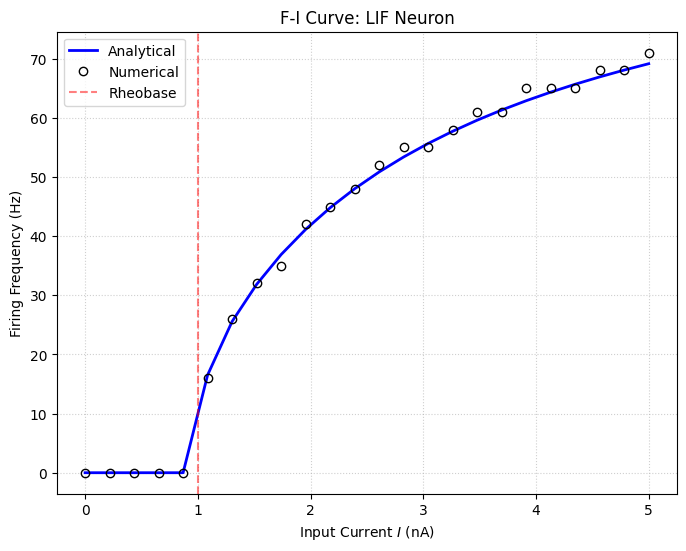

In [15]:
# @title Frequency-Current curve - change simulation times and current steps { run: "auto" }
T = 310 #@param {type:"slider", min:10, max:5000, step:20}
n_step = 24 #@param {type:"slider", min:2, max:200, step:2}

import numpy as np
import matplotlib.pyplot as plt

def get_analytical_frequency(I):
    """
    Calculates the steady-state firing rate analytically.
    """
    I_rheobase = (θ - E) / R

    # If current is too low to reach threshold, frequency is 0
    if I <= I_rheobase:
        return 0.0

    # Calculation of Inter-Spike Interval (ISI)
    # Formula: tau * ln( (RI + E - E_reset) / (RI + E - θ) )
    # Note: In this model, E_reset is equal to E

    T_isi = R * C * np.log(R * I / (R * I + E - θ))

    # Frequency is 1 / (ISI + Refractory Period)
    # We multiply by 1000 to convert ms to seconds (Hz)
    return 1000.0 / (T_isi + Tarp)

# --- 3. Numerical Simulation ---
def run_simulation(I):
  time, W, freq = IF(I, T=T)
  return freq

# --- 4. Generate the F-I Curve ---
current_range = np.linspace(0, 5, n_step) # Current from 0 to 5 nA
freq_analytical = [get_analytical_frequency(i) for i in current_range]
freq_numerical = [run_simulation(i) for i in current_range]

# --- 5. Plotting ---
plt.figure(figsize=(8, 6))
plt.plot(current_range, freq_analytical, label='Analytical', color='blue', linewidth=2)
plt.plot(current_range, freq_numerical, 'o', label='Numerical', color='black', markerfacecolor='none')

plt.axvline((θ - E)/R, color='red', linestyle='--', alpha=0.5, label='Rheobase')
plt.title('F-I Curve: LIF Neuron')
plt.xlabel('Input Current $I$ (nA)')
plt.ylabel('Firing Frequency (Hz)')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

## (intracellular) Calcium Dynamics (simplified description)

This model describes the intracellular calcium concentration $[Ca^{2+}](t)$ as a simple "leaky integrator." It assumes that calcium enters the cell instantaneously via voltage-gated Calcium-channels, during an action potential (modeled as a discrete *jump* of amplitude $\Delta$) and then that it is removed or buffered by cellular mechanisms (pumps like SERCA/PMCA, exchangers like NCX) modeled as a linear decay with rate $\beta$.

### The Mathematical Model

1.  **Influx (Action Potential):**
    $$[Ca^{2+}] \leftarrow [Ca^{2+}] + \Delta$$
    This occurs every time the neuron fires (frequency $f$).

2.  **Decay (Buffering/Extrusion):**
    Between spikes, concentration decays to a baseline $c_{min}$:
    $$\frac{d[Ca^{2+}]}{dt} = -\beta ([Ca^{2+}] - c_{min})$$


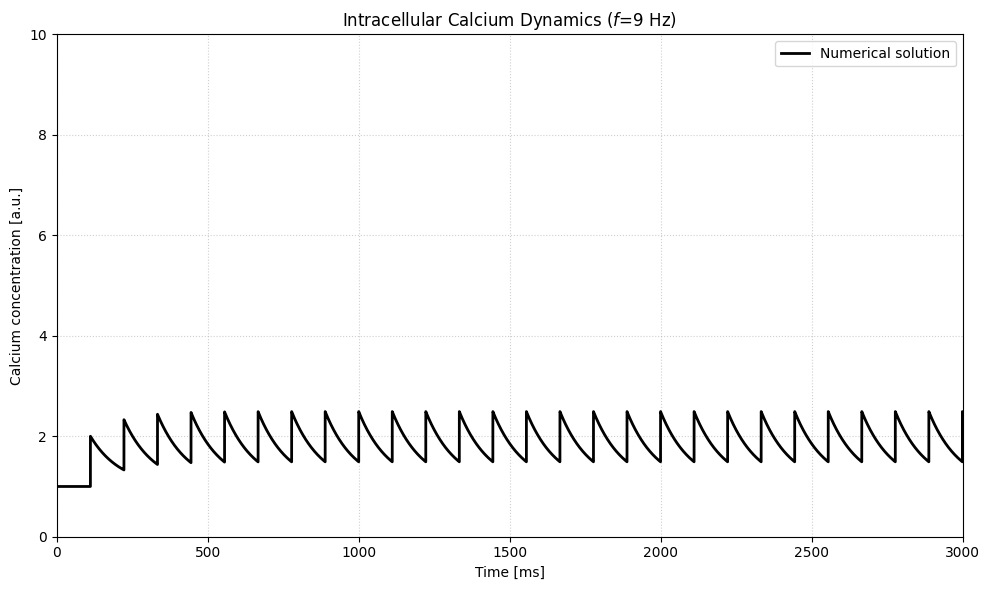

In [40]:
# @title Calcium dynamics - change simulation times and current steps { run: "auto" }

import numpy as np
import matplotlib.pyplot as plt

# @markdown ### Simulation Parameters
T = 3000.0   # @param {type:"number"}
dt = 0.05    # @param {type:"number"}

# @markdown ### Biological Parameters
# @markdown **f**: Frequency of action potentials (Hz).
f = 9      # @param {type:"slider", min:0, max:20, step:0.5}

# @markdown **Delta**: Influx of Ca++ per spike (arbitrary units).
Delta = 1.0  # @param {type:"number"}

# @markdown **beta**: Decay rate (1/ms). Represents buffering and extrusion speed.
beta = 0.01  # @param {type:"number"}

# @markdown **cmin**: Baseline Ca++ concentration.
cmin = 1   # @param {type:"number"}


def run_simulation(f, T, dt, Delta, beta, cmin):
    """
    Simulates intracellular Calcium dynamics.
    """
    # Time setup
    time = np.arange(0, T + dt, dt)
    N = len(time)
    W = np.zeros(N)

    # Calculate spike timing (Inter-Spike Interval)
    if f > 0:
        isi = 1000.0 / f # ISI in ms
        M = int(np.floor(isi / dt)) # Steps between spikes
    else:
        M = 10**9 # Effectively infinite if f=0

    # Initial conditions
    c = cmin

    # Numerical Integration (Euler Method)
    for k in range(N):
        # Check if this time step corresponds to a spike event
        # We use (k+1) to align with 1-based indexing logic of the original script
        # implying the first spike happens after one full ISI period.
        if M > 0 and (k + 1) % M == 0:
            c = c + Delta # Sudden influx
        else:
            # Linear decay dynamics: dc/dt = -beta * (c - cmin)
            # c_new = c_old + dt * dc/dt
            c = c - dt * beta * (c - cmin)

        W[k] = c

    return time, W

# Run the simulation
time, W = run_simulation(f, T, dt, Delta, beta, cmin)

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(time, W, color='black', linewidth=2, label='Numerical solution')

plt.title(f'Intracellular Calcium Dynamics ($f$={f} Hz)')
plt.xlabel('Time [ms]')
plt.ylabel('Calcium concentration [a.u.]')

# Visual settings from the original notebook
plt.xlim(0, T)
plt.ylim(0, 10) # Fixed y-limit to see accumulation effects clearly
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

## Adaptive (leaky) Integrate-and-Fire

We are moving from a 1D system to a 2D system:

1.  **Membrane Potential ($V$):** We add an inhibitory adaptation current $-w$ to the equation.

    $$C \frac{dV}{dt} = \frac{E - V}{R} - w + I$$

2.  **Adaptation Current ($w$):** This variable decays with time constant $\tau_w$ and jumps by amount $b$ after every spike.

    $$\tau_w \frac{dw}{dt} = - w$$

    $$\text{If spike: } w \leftarrow w + b$$


In [46]:
# @title Simulation functions definition

def aIF(I, T=300., tau_w=100., b=5.0):
  """
  Simulates the Adaptive LIF model (LIF + SFA) for a constant current I.

  Parameters:
  I     : Input current [nA]
  T     : Simulation duration [ms]
  tau_w : Adaptation time constant [ms]
  b     : Spike-triggered adaptation [nA] (the "jump" in w)
  """
  # Set up time array
  time = np.arange(0, T + Δt, Δt)
  N = len(time)

  W = np.zeros(N)   # Array containing V as the time goes by
  Adapt = np.zeros(N) # Array containing w (adaptation current)
  Nspikes = 0         # Counter for the number of spikes

  # Initial conditions:
  V = E           # Membrane voltage of the cell [mV]
  w = 0.0         # Adaptation current [nA]
  ko = -100       # Last time (as index) an action potential occurred

  # Euler method ---------------------------------------------------------------
  for k in range(N): # Loop over each discrete step for time t

    if V >= θ:     # Ops! V just exceeded the threshold: an AP will occur!
      W[k] = Vmax  # This is only "aesthetic"
      V = E        # V is then re-set to the resting potential, after an AP.
      w = w + b    # SFA: Increment adaptation current
      ko = k       # The last time an AP occurred is updated with the current time.
      Nspikes += 1
    elif (k - ko) < (Tarp / Δt): # Otherwise, is the neuron still "refractory" ?
      V = E        # Then V does not change in time: it must be kept "clamped"
      W[k] = E
      # Adaptation current w continues to decay even during refractory period
      dw_dt =  - w / tau_w
      w = w + dw_dt * Δt
    else:            # Otherwise
      # V evolves, integrating I... (Euler step)
      dV_dt = ((E - V) / R - w + I) / C
      V = V + dV_dt * Δt
      W[k] = V

      dw_dt = - w / tau_w
      w = w + dw_dt * Δt
      Adapt[k] = w

  freq = (1000. * Nspikes) / T

  # Returns time, Voltage, Frequency, and the Adaptation variable w
  return time, W, round(freq), Adapt

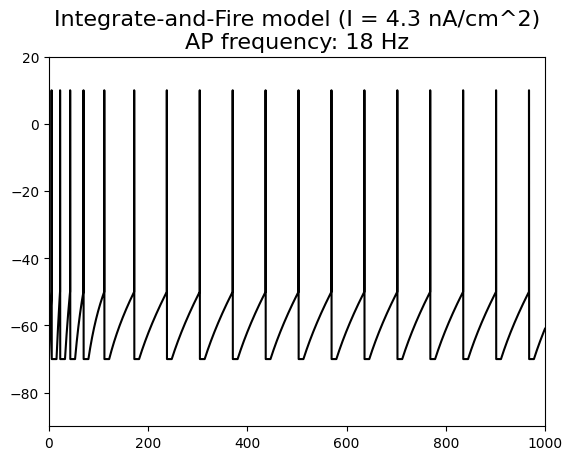

In [80]:
# @title After running this cell manually, it will auto-run if you change the selected value. { run: "auto" }
I = 4.3 #@param {type:"slider", min:-1, max:5, step:0.1}
tau_w = 231 #@param {type:"slider", min:1, max:1000, step:10}
b = 1 #@param {type:"slider", min:0, max:20, step:1}


T_sim = 1000. # Set T for this simulation
time, W, freq, Adapt = aIF(I, T=T_sim, tau_w=tau_w, b=b)

# Analytical solution for the sub-threshold RC circuit
# Plotting
plt.plot(time, W, 'k') # Call the helper function

# Add titles and limits
plt.title(f"Integrate-and-Fire model (I = {I:.1f} nA/cm^2)\nAP frequency: {freq} Hz", fontsize=16)
plt.xlim(0, T_sim)
plt.ylim(-90, 20)
plt.show()

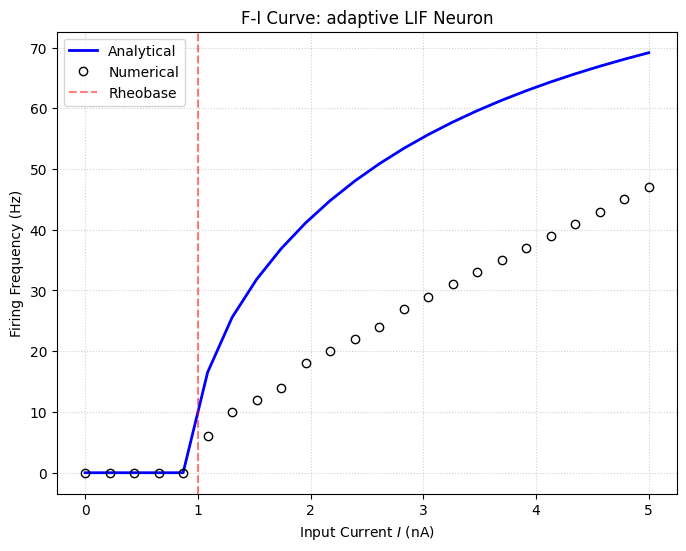

In [95]:
# @title Frequency-Current curve - change simulation times and current steps { run: "auto" }
T = 510 #@param {type:"slider", min:10, max:5000, step:20}
n_step = 24 #@param {type:"slider", min:2, max:200, step:2}
tau_w = 71 #@param {type:"slider", min:1, max:1000, step:10}
b = 1 #@param {type:"slider", min:0, max:20, step:1}

import numpy as np
import matplotlib.pyplot as plt

def get_analytical_frequency(I):
    """
    Calculates the steady-state firing rate analytically.
    """
    I_rheobase = (θ - E) / R

    # If current is too low to reach threshold, frequency is 0
    if I <= I_rheobase:
        return 0.0

    # Calculation of Inter-Spike Interval (ISI)
    # Formula: tau * ln( (RI + E - E_reset) / (RI + E - θ) )
    # Note: In this model, E_reset is equal to E

    T_isi = R * C * np.log(R * I / (R * I + E - θ))

    # Frequency is 1 / (ISI + Refractory Period)
    # We multiply by 1000 to convert ms to seconds (Hz)
    return 1000.0 / (T_isi + Tarp)

# --- 3. Numerical Simulation ---
def run_simulation(I):
  time, W, freq, Adapt = aIF(I, T=T, tau_w=tau_w, b=b)
  return freq

# --- 4. Generate the F-I Curve ---
current_range = np.linspace(0, 5, n_step) # Current from 0 to 5 nA
freq_analytical = [get_analytical_frequency(i) for i in current_range]
freq_numerical = [run_simulation(i) for i in current_range]

# --- 5. Plotting ---
plt.figure(figsize=(8, 6))
plt.plot(current_range, freq_analytical, label='Analytical', color='blue', linewidth=2)
plt.plot(current_range, freq_numerical, 'o', label='Numerical', color='black', markerfacecolor='none')

plt.axvline((θ - E)/R, color='red', linestyle='--', alpha=0.5, label='Rheobase')
plt.title('F-I Curve: adaptive LIF Neuron')
plt.xlabel('Input Current $I$ (nA)')
plt.ylabel('Firing Frequency (Hz)')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()